# Akamai SIA Analytics API Client

## Overview

In this [Jupyter](https://jupyter.org/) notebook we provide examples using the [Secure Mobi Analytics API's](https://developer.securemobi.net/reference/introduction) to generate reports
for:
- Device Activity summary for an account
- Device Usage for an account
- Device Status

We use [Pandas](https://pandas.pydata.org/), [NumPy](https://numpy.org/) and [Matplotlib](https://matplotlib.org/) Python modules to manipulate and visualize the data returned by the API's.

## Pre-requisites

To access the API's you will need to obtain API credentials for your account, follow the [Quick Start](https://developer.securemobi.net/docs/quick-start) instructions to obtain
API_SECRET and API_KEY for your account. You should **NEVER** hardcode these into your code - use environment variables, vault or a cloud based secrets manager.

If you are using Tenant Level credentials you will need to specify the Account ID in the _Configuration Details_ section below. 
e.g. `ACCOUNT_ID = "6bf4add5-a6db-457f-b4af-4f76f3b0dee4"`

In this notebook you are prompted to enter the API key and secret if you have not defined the following variables:
- SECURE_MOBI_API_KEY
- SECURE_MOBI_API_SECRET

### Dependencies
- Python >= 3.8
- [Requests](https://docs.python-requests.org/) - HTTP requests
- [pandas](https://pandas.pydata.org/) and [NumPy](https://numpy.org/)
- [matplotlib](https://pypi.org/project/matplotlib/) - graphing library
- [openpyxl](https://pypi.org/project/openpyxl/) - to generate Excel spreadsheets

In [1]:
import sys
!{sys.executable} -m pip install pandas matplotlib requests openpyxl

In [2]:
from typing import Dict, Tuple, Union, List, Any, Generator
from datetime import datetime, timedelta, timezone
from collections import Counter
import json
import os
from itertools import chain
import pandas as pd
import numpy as np
import base64
import time
import pprint
import logging
import getpass
from dateutil.relativedelta import relativedelta


# matplotlib

Import [matplotlib](https://matplotlib.org/devdocs/index.html) and set for inline display of charts

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import matplotlib.dates as mdates


## Python requests library
Using Python `requests` library to access the API

In [4]:
import requests
from requests.auth import AuthBase
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

from concurrent.futures import ThreadPoolExecutor


### HTTP Requests settings

Create a HTTP _Session_ object and attach an adapter to manage retries.

To avoid being throttled (HTTP 429) we set a sensible backoff retry strategy for requests. Backoff exponentially starting with 1 second

In [5]:
retry_strategy = Retry(
    total=3,
    backoff_factor = 2,
    status_forcelist=[429],
    allowed_methods=["HEAD", "GET", "OPTIONS", "POST"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount("https://", adapter)
http.mount("http://", adapter)


## Logging configuration

Set the log level for the root logger, specify urllib3 log level separately as we don't want to see the detailed urllib3 HTTP logging.

In [6]:
from http.client import HTTPConnection
HTTPConnection.debuglevel = 0

logging.basicConfig() # you need to initialize logging, otherwise you will not see anything from requests
logger = logging.getLogger() # Root logger
logger.setLevel(logging.INFO)
requests_log = logging.getLogger("urllib3")
requests_log.setLevel(logging.INFO)
requests_log.propagate = True

## Configuration Details

Set the API endpoint URL and configure API credentials.

For credentials we try environment variables first, otherwise fallback to prompting.

In [7]:
URL = "https://api.securemobi.net/v2"

ACCOUNT_ID = None # ID defaults to the account associated with the account level credentials

API_KEY = os.getenv('SECURE_MOBI_API_KEY')
API_SECRET = os.getenv('SECURE_MOBI_API_SECRET')

if API_KEY is None:
    API_KEY = getpass.getpass('Enter API Key')
    API_SECRET = getpass.getpass('Enter API Secret')
    

Enter API Key ····································
Enter API Secret ············································


# Authentication

The API uses OAuth2 to grant a bearer token. Tokens are issued with a limited lifetime, the code belows fetches, caches and manages the token expiry time.
The Bearer token is fetched using a custom authenticator.

## Custom authenticator

The AkamaiAuth class below implements the `requests` `AuthBase` class to manage the API Bearer Token, refreshing the token when required.
Attach the authenticator class to http session.

**NOTE**: Python Requests does have an OAuth2 helper - but for illustration purposes we provide our own custom authenticator.

In [8]:
class AkamaiAuth(AuthBase):
    """Attaches Authentication to the given Request object."""
    def __init__(self, username, password) -> None:
        self.basic_auth = basic_auth = base64.b64encode(f"{username}:{password}".encode('ASCII')).decode('ASCII')
        self.last_auth = None
        self.token_expires = 0

    def __call__(self, r) -> str :
        # check first to see if we already have a bearer token and that it has not expired
        epoch_now = datetime.now(timezone.utc).timestamp()
        if self.last_auth is None or (epoch_now + 60) >= self.token_expires: # Add 60 seconds margin
            # Get a new bearer token
            headers = { "Accept":"application/json", "Content-Type":"application/x-www-form-urlencoded", "Authorization": f"Basic {self.basic_auth}"}
            payload = { "grant_type": "client_credentials"}
            resp = requests.post(f"{URL}/oauth2/token", data=payload, headers=headers)
            if resp.status_code != 200:
                raise Exception(f"Authentication error getting bearer token: {resp.status_code}:{resp.reason}")
            self.last_auth = resp.json()
            self.token_expires = epoch_now + self.last_auth['expires_in']
        r.headers['Authorization'] = f'Bearer {self.last_auth["access_token"]}'
        return r
    
# Bind the token to our http Session
http.auth = AkamaiAuth(API_KEY, API_SECRET)

In [9]:
ACCOUNT_ID_HTTP_HEADER_NAME = "X-Asavie-Account-Id"

# API methods
The section below provides a set of methods to access the API's

## Util methods

In [10]:
class IllegalArgumentError(ValueError):
    pass

def _api_request(method:str, path:str, params:dict, headers:dict, tenant_id:str, json=None, debug=False) -> Generator[dict, None, None]:
    """ Generic API request usings the http session with the OAuth Authentication bound. API returns two types of responses
    Collections containing top level keys items and continuation_token or simple responses as JSON array.
    
    Returns: A generator as the collections can be paged."""
    
    method = method.upper()
    if method not in ("GET", "POST"):
        raise NotImplementedError(f"HTTP method {method} not supported")
    if tenant_id is not None:
        headers['X-Asavie-Tenant-Id'] = tenant_id

    more_data = True
    while more_data:
        resp = http.request(method, f"{URL}/{path}", headers=headers, params=params, json=json)
        if resp.status_code != 200:
            raise Exception(f"API Request Error: {resp.status_code} / {resp.reason} {resp.text}")
        if debug:
            print(resp.text)
        data = resp.json()
        continuation_token = data.get('continuation_token', None)
        
        # Responses are either collections (have items and continuation tokens) or non collections
        if 'items' not in data.keys():
            yield data
            return # Not a collection so generator is complete
        
        items = data.get('items', [])
        if len(items) == 0:
            return
        if not continuation_token:
            more_data = False
        else:
            params['continuation_token'] = continuation_token
        yield items

        
def yesterday_utc() -> datetime:
    """ Return yesterday datetime with time parts set to zero, i.e. midnight yesterday"""
    now = datetime.now(timezone.utc)
    # zero the time portion 
    return (now.replace(hour=0,minute=0,second=0,microsecond=0) - timedelta(days=1))
    
        
def start_of_day_utc() -> datetime:
    """ Return datetime for start of today. """
    now = datetime.now(timezone.utc)
    # zero the time portion, even though backend does this. 
    return now.replace(hour=0,minute=0,second=0,microsecond=0)
    
        
def get_date_range(num_periods:int, agg_period:str, end_time:datetime) -> Dict[str,str]:
    """ Construct and return a dictionary with the date range object. """
    if end_time is None:
        # default to yesterday if the end_time is not specified
        end_time = yesterday_utc()
    else:
        end_time = end_time.replace(hour=0,minute=0,second=0,microsecond=0).astimezone(timezone.utc)
        if (end_time > yesterday_utc()):
            raise Exception("End time cannot be today or in the future")
    if agg_period == "day": # Note that to_date is inclusive
        delta = timedelta(days=num_periods - 1)
    elif agg_period == "week":
        delta = timedelta(weeks=num_periods)
    elif agg_period == "month":
        delta = relativedelta(months=num_periods)
    else:
        raise IllegalArgumentError(f"Aggregate period {agg_period} not valid")
        
    start_time = end_time - delta
    return {
        "from_date": start_time.isoformat(),
        "to_date": end_time.isoformat(),
        "aggregated_by": agg_period
    }

ENG_FORMATTER = EngFormatter(unit='B', places=1)


DATE_RANGES = (
    "last_3_days",
    "last_7_days",
    "last_30_days",
    "current_quote_cycle_month",
    "day",
    "month"
)

BEARERS = (
    "ethernet/wifi",
    "cellular"
)
    
    
def get_interval_range(date_range:str, start_date:datetime=None) -> Dict:
    if date_range not in DATE_RANGES:
        raise IllegalArgumentError(f"Invalid Date range: {date_range}")
    if date_range in ("day", "month") and start_date is None:
        raise IllegalArgumentError("start date must be specified when range is month or day")
    body = { "interval": date_range }
    if start_date:
        body["date"] = start_date
    return body
        
                    

## Account Level methods

In [11]:
def get_account_details(account_id:str=None) -> Generator[dict, None, None]:
    """ Docs: https://developer.securemobi.net/reference/getaccount-1
    Retrieve the Account details and return a Dict.
    
    Note if you are using Account level credentials the account ID defaults to
    the API_KEY account.
    """
    path = "account"
    params = {}
    headers = {}
    if account_id is not None:
        headers[ACCOUNT_ID_HTTP_HEADER_NAME] = account_id
    return next(_api_request("GET", path, params, headers, tenant_id=None, debug=False))    


def get_dns_blocks_top_slds_by_account(account_id:str, interval:str, bearer:str=None, limit:int=50) -> Generator[dict, None, None]:
    """ Docs: https://developer.securemobi.net/reference/getdnsblockstopsecondleveldomains
    Get DNS blocks for the top second level domains by interval.
    """
    path = "account/analytics/dns-blocks/second-level-domains/topn"
    params = {}
    headers = { ACCOUNT_ID_HTTP_HEADER_NAME: account_id }
    data = {'interval': interval, 'limit': limit}
    if bearer is not None:
        data['bearer'] = bearer
    return chain(*_api_request("POST", path, params, headers, tenant_id=None, json=data))


def get_dns_blocks_time_series_by_account(account_id:str, num_periods:int, agg_period:str, end_time:datetime=None, 
                                          bearer:str=None) -> Generator[dict, None, None]:
    """ Docs: https://developer.securemobi.net/reference/getaccountdnsblockstimeseries
    Get account DNS blocks by interval.
    """
    path = "account/analytics/dns-blocks/time-series"
    params = {}
    headers = { ACCOUNT_ID_HTTP_HEADER_NAME: account_id }
    data = get_date_range(num_periods, agg_period, end_time)
    if bearer is not None:
        data['bearer'] = bearer
    return chain(*_api_request("POST", path, params, headers, tenant_id=None, json=data))


def get_device_activity_summary_by_account(account_id:str) -> Generator[dict, None, None]:
    """ Docs: https://developer.securemobi.net/reference/getaccountdeviceactivitysummary
    Get count of active devices broken down by periods.
    """
    path = "account/analytics/device-activity/summary"
    params = {}
    headers = { ACCOUNT_ID_HTTP_HEADER_NAME: account_id }
    # Summary does not return items or continuation token, so just get the next and only one.
    return next(_api_request("POST", path, params, headers, tenant_id=None))


def get_devices_data_usage_by_account(account_id:str, num_periods:int, 
                                      agg_period:str, end_time:datetime=None, 
                                      bearer:str=None, apn_operator:str=None, limit:int=50) -> Generator[dict, None, None]:
    """ Docs: https://developer.securemobi.net/reference/getdevicesdatausage
    Get a breakdown of device usage under an account.
    """
    path = "account/analytics/data-usage/devices"
    params = {}
    headers = { ACCOUNT_ID_HTTP_HEADER_NAME: account_id }
    data = get_date_range(num_periods, agg_period, end_time)
    data['limit'] = limit
    if bearer is not None:
        data['bearer'] = bearer
    if apn_operator is not None:
        data['apn_operator'] = apn_operator
    return chain(*_api_request("POST", path, params, headers, tenant_id=None, json=data))


def get_device_data_usage_by_account_time_series(account_id:str, num_periods:int, agg_period:str, end_time:datetime=None,
                                                 device_id:str=None, phone_number:str=None) -> Generator[dict, None, None]:
    """ Docs: https://developer.securemobi.net/reference/getdevicedatausagetimeseries
    Get device data usage with the option to find by Phone Number or Device ID.
    """
    path = "account/analytics/data-usage/device/time-series"
    params = {}
    headers = { ACCOUNT_ID_HTTP_HEADER_NAME: account_id }
    data = get_date_range(num_periods, agg_period, end_time)
    if device_id and phone_number:
        raise IllegalArgumentError("You cannot specify both device_id and phone_number")
    if device_id is not None:
        data['device_id'] = device_id
    if phone_number is not None:
        data['phone_number'] = phone_number
    # Not a collection so use next
    return next(_api_request("POST", path, params, headers, tenant_id=None, json=data, debug=False))


def get_device_activity_by_account_time_series(account_id:str, num_periods:int, agg_period:str, end_time:datetime=None) -> Generator[dict, None, None]:
    """ Docs: https://api.securemobi.net/v2/account/analytics/device-activity/time-series
    Get count of active devices as a time series
    """
    path = "account/analytics/device-activity/time-series"
    params = {}
    headers = { ACCOUNT_ID_HTTP_HEADER_NAME: account_id }
    data = get_date_range(num_periods, agg_period, end_time)
    return chain(*_api_request("POST", path, params, headers, tenant_id=None, json=data, debug=False))


def get_account_data_usage_time_series(account_id:str, 
                                       num_periods:int, agg_period:str, end_time:datetime=None, bearer:str=None) -> Generator[dict, None, None]:
    """ Docs: https://developer.securemobi.net/reference/getaccountdatausagetimeseries
    Get account data usage by interval.
    """
    path = "account/analytics/data-usage/time-series"
    params = {}
    headers = { ACCOUNT_ID_HTTP_HEADER_NAME: account_id }
    data = get_date_range(num_periods, agg_period, end_time)
    if bearer is not None:
        data['bearer'] = bearer
    return chain(*_api_request("POST", path, params, headers, tenant_id=None, json=data))


def get_account_device_top_data_usage(account_id:str, date_range:str, start_date:datetime=None, bearer:str=None, limit:int=None) -> Generator[dict, None, None]:
    """ Docs: https://developer.securemobi.net/reference/getdatausagetopdevices
    Get data usage for top devices by interval.
    """
    path = "account/analytics/data-usage/devices/topn"
    params = {}
    headers = { ACCOUNT_ID_HTTP_HEADER_NAME: account_id }
    data = get_interval_range(date_range, start_date=start_date, bearer=bearer)
    if bearer:
        if bearer not in BEARERS:
            raise IllegalArgumentError(f"If bearer is specified must one of: [{', '.join(BEARERS)}]")
        data["bearer"] = bearer
    if limit:
        data['limit'] = limit
    return chain(*_api_request("POST", path, params, headers, tenant_id=None, json=data))


def get_account_top_slds(account_id:str, date_range:str, start_date:datetime=None, bearer:str=None, limit:int=None) -> Generator[dict, None, None]:
    """ Docs: https://developer.securemobi.net/reference/getinternetusagetopsecondleveldomains
    Get internet usage for top second level domains by interval.
    """
    path = "account/analytics/internet-usage/second-level-domains/topn"
    params = {}
    headers = { ACCOUNT_ID_HTTP_HEADER_NAME: account_id }
    data = get_interval_range(date_range, start_date=start_date, bearer=bearer)
    if bearer:
        if bearer not in BEARERS:
            raise IllegalArgumentError(f"If bearer is specified must one of: [{', '.join(BEARERS)}]")
        data["bearer"] = bearer
    if limit:
        data['limit'] = limit
    return chain(*_api_request("POST", path, params, headers, tenant_id=None, json=data))


def list_account_devices(account_id:str) -> Generator[dict, None, None]:
    """ Docs: https://developer.securemobi.net/reference/getdevices
    List All Devices.
    """
    path = "account/devices"
    params = {'limit': 150 }
    headers = { ACCOUNT_ID_HTTP_HEADER_NAME: account_id }
    return chain(*_api_request("GET", path, params, headers, tenant_id=None, debug=False))

## Higher level functions

In [12]:
def display_account_details(account_id:str=None):
    """ Print selected details of account."""
    details = get_account_details(account_id)
    print(f"Account: {details['name']} ({details['id']})\nCreated: {details['created_date']}")


def get_devices_data_usage_by_account_total(account_id:str, num_periods:int, agg_period='day', end_time:datetime=None) -> int:
    """ Sum the interface totals per device and return the device total """
    return sum([sum([interface['total_bytes'] for interface in device['interfaces']])
            for device in 
                get_devices_data_usage_by_account(account_id, num_periods=num_periods, agg_period=agg_period, end_time=end_time)]
              )


def get_account_data_usage_time_series_df(account_id:str, num_periods:int, agg_period:str, end_time:datetime=None) -> pd.DataFrame:
    """ Return a dataframe with account time series usage. """
    df = pd.DataFrame(get_account_data_usage_time_series(account_id, num_periods, agg_period, end_time))
    df['account_id'] = account_id
    return df


def get_account_device_activity_time_series_df(account_id:str, num_periods:int, agg_period:str, end_time:datetime=None) -> pd.DataFrame:
    """ Return a dataframe with account device activity as a time series. """
    df = pd.DataFrame(get_device_activity_by_account_time_series(account_id, num_periods, agg_period, end_time))
    df['account_id'] = account_id
    return df


def get_account_device_activity_time_series_df(account_id:str, num_periods:int, agg_period:str, end_time:datetime=None) -> pd.DataFrame:
    """ Return a dataframe with account device activity as a time series. """
    df = pd.DataFrame(get_device_activity_by_account_time_series(account_id, num_periods, agg_period, end_time))
    df['account_id'] = account_id
    return df


def get_account_device_top_data_usage_df(account_id:str, date_range:str, start_date:datetime=None, bearer:str=None, limit:int=None) -> pd.DataFrame:
    df = pd.DataFrame(get_account_device_top_data_usage(ACCOUNT_ID, date_range, start_date, bearer, limit))
    df['account_id'] = account_id
    return df


## Display some basic account details

In [14]:
display_account_details(ACCOUNT_ID)

Account: Akamai Sample Account  (6bf4add5-a6db-457f-b4af-4f76f3b0dee4)
Created: 2022-01-01T08:00:00.0000000Z


## Account Devices

Retrieve the list of devices for this account and then read into a Pandas DataFrame, then plot info about the devices.

In [15]:
devices = list(list_account_devices(ACCOUNT_ID))
print(f"Total Number of Devices for Account {ACCOUNT_ID}: {len(devices)}")

Total Number of Devices for Account 6bf4add5-a6db-457f-b4af-4f76f3b0dee4: 1003



Load the JSON response into a Pandas DataFrame and then display the Device Status aggregates

In [27]:
# Load the data into a Pandas DataFrame
devices_df = pd.read_json(json.dumps(devices))
if len(devices_df) > 0:
    device_status = devices_df.status.value_counts()
else:
    device_status = []

device_status


never_connected    717
disconnected       144
connected          142
Name: status, dtype: int64

## Plot Device Status as Pie chart

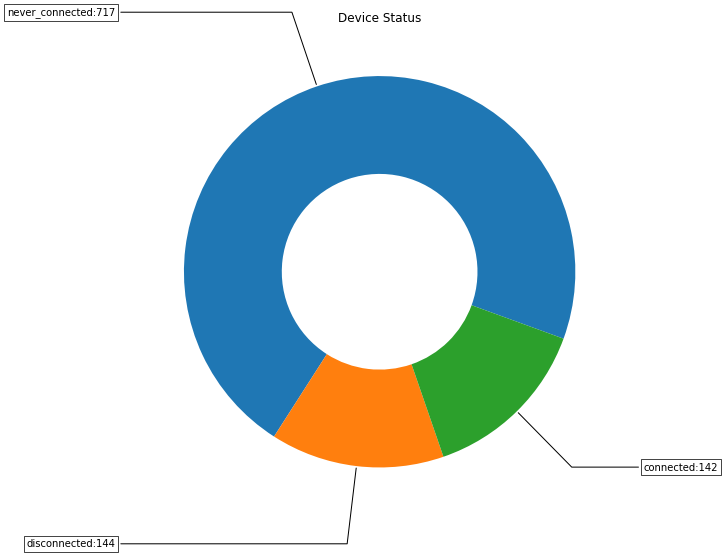

In [28]:
if len(device_status) > 0:
    fig, ax = plt.subplots(figsize=(18, 9), subplot_kw=dict(aspect="equal"))


    wedges, texts = ax.pie(device_status.values, wedgeprops=dict(width=0.5), startangle=-20)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        t = f"{device_status.index[i]}:{device_status.values[i]}"
        ax.annotate(t, xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    ax.set_title("Device Status")

    plt.show()

## Use the Account Level time series usage to determine how many bytes were used

In [18]:
num_days = 21
daily_time_series_df = get_account_data_usage_time_series_df(ACCOUNT_ID, num_periods=num_days, agg_period='day')
if len(daily_time_series_df) > 0:
    total = sum(daily_time_series_df['total_bytes'])
    print(f"Total Number of bytes used for AccountID: {ACCOUNT_ID} for last {num_days} days: {total} ({ENG_FORMATTER.format_data(total)})")

Total Number of bytes used for AccountID: 6bf4add5-a6db-457f-b4af-4f76f3b0dee4 for last 21 days: 29132068727 (29.1 GB)


# List time series usage

In [19]:
usage_rows = get_account_data_usage_time_series(ACCOUNT_ID, 7, 'day')
for row in usage_rows:
    print(row)

{'date': '2022-02-17T00:00:00.000Z', 'upload_bytes': 198299661, 'download_bytes': 1089178705, 'total_bytes': 1287478366}
{'date': '2022-02-18T00:00:00.000Z', 'upload_bytes': 199010360, 'download_bytes': 2278008980, 'total_bytes': 2477019340}
{'date': '2022-02-19T00:00:00.000Z', 'upload_bytes': 269614230, 'download_bytes': 1186100190, 'total_bytes': 1455714420}
{'date': '2022-02-20T00:00:00.000Z', 'upload_bytes': 308330414, 'download_bytes': 306937856, 'total_bytes': 615268270}
{'date': '2022-02-21T00:00:00.000Z', 'upload_bytes': 189503015, 'download_bytes': 455801045, 'total_bytes': 645304060}
{'date': '2022-02-22T00:00:00.000Z', 'upload_bytes': 348919029, 'download_bytes': 769828007, 'total_bytes': 1118747036}
{'date': '2022-02-23T00:00:00.000Z', 'upload_bytes': 465998319, 'download_bytes': 747690552, 'total_bytes': 1213688871}


# Plot Byte Usage totals by day
## Plot Downloads and Uploads separately

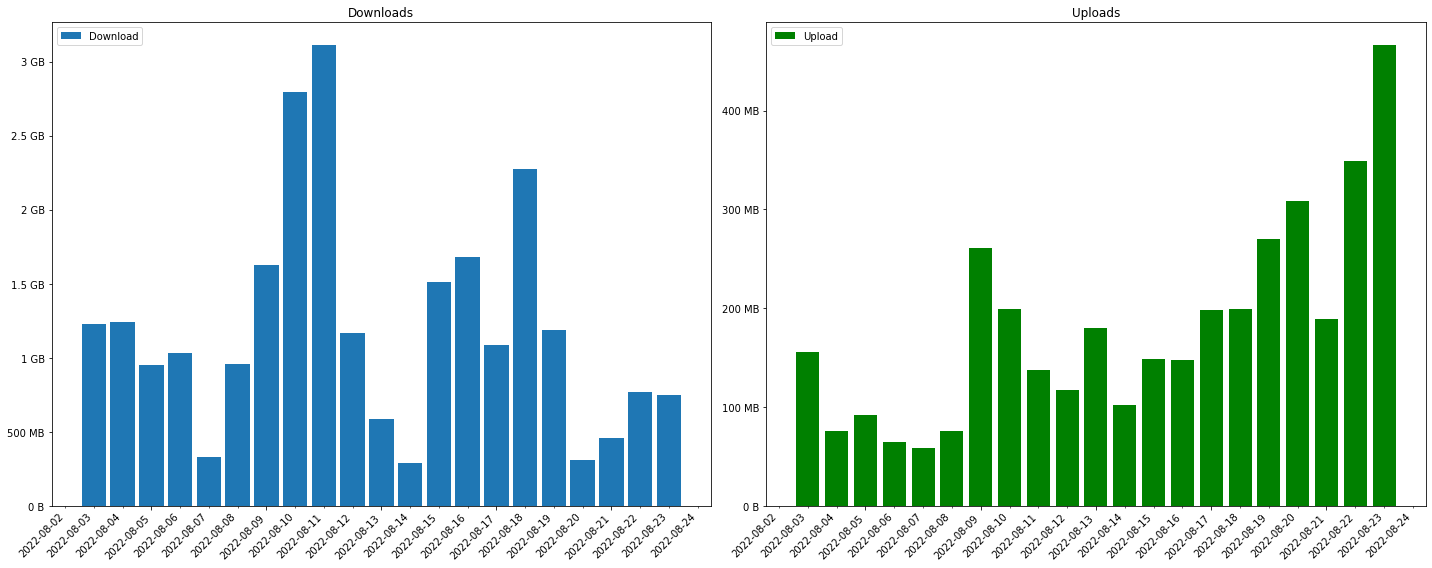

In [20]:
if len(daily_time_series_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    width = 0.35

    plt.xticks(rotation='vertical') 

    daily_time_series_df['dt'] = pd.to_datetime(daily_time_series_df.date)
    ax1.yaxis.set_major_formatter(EngFormatter(unit='B'))
    ax1.xaxis.set_minor_formatter(
        mdates.DateFormatter(fmt='%Y-%m-%d'))
    ax1.xaxis.set_minor_locator(mdates.DayLocator())
    width = 0.85
    ax1.bar(daily_time_series_df['dt'], daily_time_series_df.download_bytes, width, label='Download')
    ax1.legend(loc='upper left')
    ax1.set_title('Downloads')
    for label in ax1.get_xticklabels(which='both'):
        label.set(rotation=45, horizontalalignment='right')


    ax2.bar(daily_time_series_df['dt'], daily_time_series_df['upload_bytes'], color='green', label='Upload')
    ax2.yaxis.set_major_formatter(EngFormatter(unit='B'))
    ax2.xaxis.set_minor_formatter(
        mdates.DateFormatter(fmt='%Y-%m-%d'))
    ax2.xaxis.set_minor_locator(mdates.DayLocator())
    ax2.set_title('Uploads')
    ax2.legend(loc='upper left')
    for label in ax2.get_xticklabels(which='both'):
        label.set(rotation=45, horizontalalignment='right')

    fig.tight_layout()
    plt.show()
else:
    print("No Daily usage data available to plot")


## Plot Usage totals stacking uploads on downloads

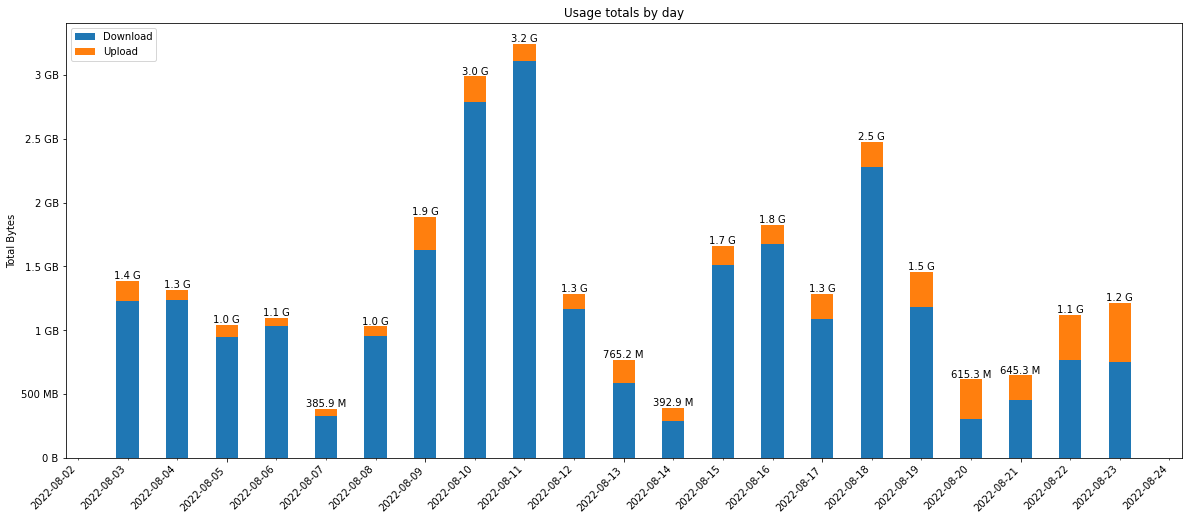

In [21]:
if len(daily_time_series_df) > 0:
    fig, ax = plt.subplots(figsize=(20,8))
    width = 0.45
    upload_color = 'tab:orange'
    download_color = 'tab:blue'

    p1 = ax.bar(daily_time_series_df['dt'], daily_time_series_df.download_bytes, width, label='Download', color=download_color)
    p2 = ax.bar(daily_time_series_df['dt'], daily_time_series_df.upload_bytes, width,
                bottom=daily_time_series_df.download_bytes, label='Upload', color=upload_color)

    ax.xaxis.set_minor_formatter(mdates.DateFormatter(fmt='%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())

    ax.yaxis.set_major_formatter(EngFormatter(unit='B'))
    ax.axhline(0, color='grey', linewidth=0.8)
    ax.set_ylabel('Total Bytes')
    ax.set_title('Usage totals by day')
    ax.legend(loc='upper left')

    labels = [EngFormatter(unit='B', places=1).format_eng(p1.datavalues[i] + p2.datavalues[i]) for i in range(len(daily_time_series_df))]
    ax.bar_label(p2, labels=labels)


    for label in ax.get_xticklabels(which='both'):
        label.set(rotation=45, horizontalalignment='right')


    plt.show()
else:
    print("No Daily usage data available to plot")


## Plot account download and upload side-by-side

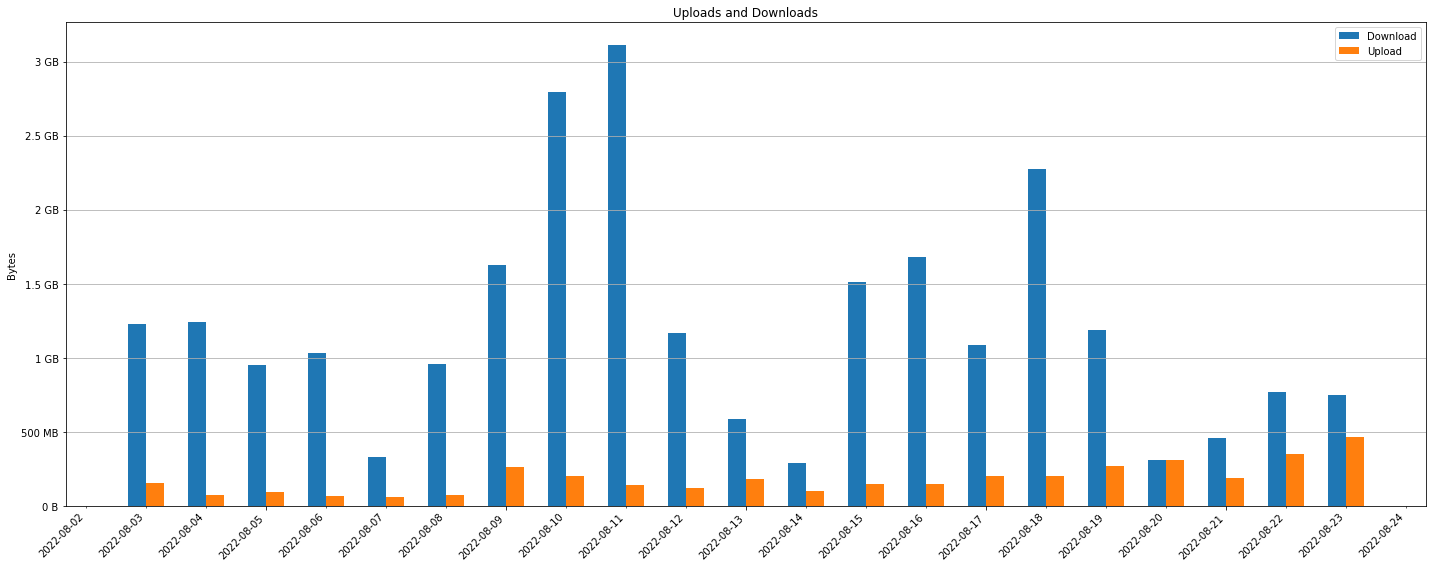

In [22]:
if len(daily_time_series_df) > 0:
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots(figsize=(20,8))
    ax.yaxis.grid()

    x= np.arange(len(daily_time_series_df))

    p1 = ax.bar(daily_time_series_df['dt'], daily_time_series_df.download_bytes, width=-width, align='edge', label='Download')
    p2 = ax.bar(daily_time_series_df['dt'], daily_time_series_df.upload_bytes, width=width, align='edge', label='Upload')

    ax.xaxis.set_minor_formatter(mdates.DateFormatter(fmt='%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())

    ax.yaxis.set_major_formatter(EngFormatter(unit='B'))


    ax.set_ylabel('Bytes')
    ax.set_title('Uploads and Downloads')
    ax.legend()


    for label in ax.get_xticklabels(which='both'):
        label.set(rotation=45, horizontalalignment='right')


    fig.tight_layout()

    plt.show()
else:
    print("No Daily usage data available to plot")


## Plot Daily usage for the account as horizontal bar chart

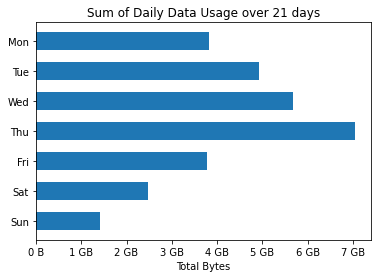

In [23]:
if len(daily_time_series_df) > 0:
    fig, ax = plt.subplots()
    width = 0.35

    usage_df = daily_time_series_df.copy()
    usage_df['dayofweek'] = pd.to_datetime(usage_df['date']).dt.weekday
    usage_df['day_name'] = pd.to_datetime(usage_df['date']).dt.day_name()


    udf = usage_df.groupby(by='day_name').agg({'upload_bytes':sum, 'download_bytes':sum, 'total_bytes':sum, 'dayofweek': 'first' }).sort_values(by='dayofweek')
    udf['num_of_days'] = len(usage_df)



    labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun')
    y_pos = np.arange(len(labels))
    # num_of_days = df.iloc[0]['num_of_days']
    num_of_days = len(daily_time_series_df)

    ax.barh(y_pos, udf['total_bytes'], align='center', height=0.6)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    formatter = EngFormatter(unit='B')
    ax.xaxis.set_major_formatter(formatter)
    ax.set_xlabel('Total Bytes')
    ax.set_title(f'Sum of Daily Data Usage over {num_of_days} days')
    plt.show()
else:
    print("No Daily usage data available to plot")




# Active devices by day

Query the device activity time series and plot as a bar chart

In [24]:
device_activity_df = get_account_device_activity_time_series_df(ACCOUNT_ID, num_periods=31, agg_period='day')
if len(device_activity_df) > 0:
    device_activity_df['dt'] = pd.to_datetime(device_activity_df.date)
    device_activity_df.drop(columns="date", inplace=True)

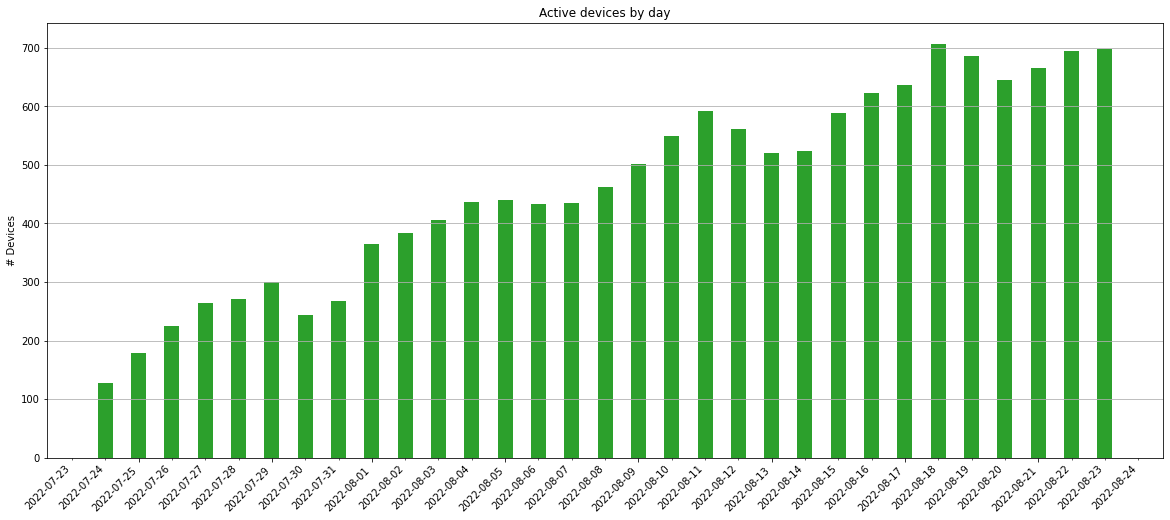

In [25]:
if len(device_activity_df):
    fig, ax = plt.subplots(figsize=(20,8))
    ax.yaxis.grid()
    width = 0.45
    bar_color = 'tab:green'

    ax.bar(device_activity_df['dt'], device_activity_df.total_active_devices, width, label='Active', color=bar_color)

    ax.xaxis.set_minor_formatter(mdates.DateFormatter(fmt='%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())

    # ax.yaxis.set_major_formatter(EngFormatter(unit='B'))
    ax.axhline(0, color='grey', linewidth=0.8)
    ax.set_ylabel('# Devices')
    ax.set_title('Active devices by day')

    for label in ax.get_xticklabels(which='both'):
        label.set(rotation=45, horizontalalignment='right')


    plt.show()
else:
    print("No Device Activity data available to plot")
    